## Trabalho Pedagógico Complementar  
### Disciplina: Machine Learning Aplicado II

**Desenvolvido por:** Keven Gomes Pereira  

---

Este notebook apresenta o desenvolvimento do **Trabalho Pedagógico Complementar** da disciplina *Machine Learning Aplicado II*, cujo objetivo é aplicar técnicas de **Aprendizado de Máquina** em um problema de **classificação de imagens de espécies de cacau**.

O trabalho utiliza **Redes Neurais Convolucionais (CNNs)** como **extratoras de características visuais**, combinadas com **Máquinas de Vetores de Suporte (SVMs)** como classificadores, permitindo avaliar o desempenho de diferentes arquiteturas de CNN na representação das imagens.

O desenvolvimento do trabalho está organizado nas seguintes etapas:

1. **Análise Exploratória dos Dados**, incluindo a distribuição das classes, inspeção da qualidade das imagens e visualização das amostras por classe;
2. **Pré-processamento dos dados**, contemplando redimensionamento, padronização e normalização das imagens;
3. **Extração de características visuais** por meio de diferentes arquiteturas de CNN pré-treinadas;
4. **Elaboração da busca em grade (Grid Search)** para ajuste dos hiperparâmetros das SVMs;
5. **Execução dos experimentos**, avaliando o desempenho das combinações de extratores e classificadores;
6. **Análise e discussão dos resultados**, considerando métricas de desempenho e comparações entre os modelos avaliados.

In [3]:
%pip install matplotlib pandas numpy scikit-learn torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms


#### Etapa 01: EDA

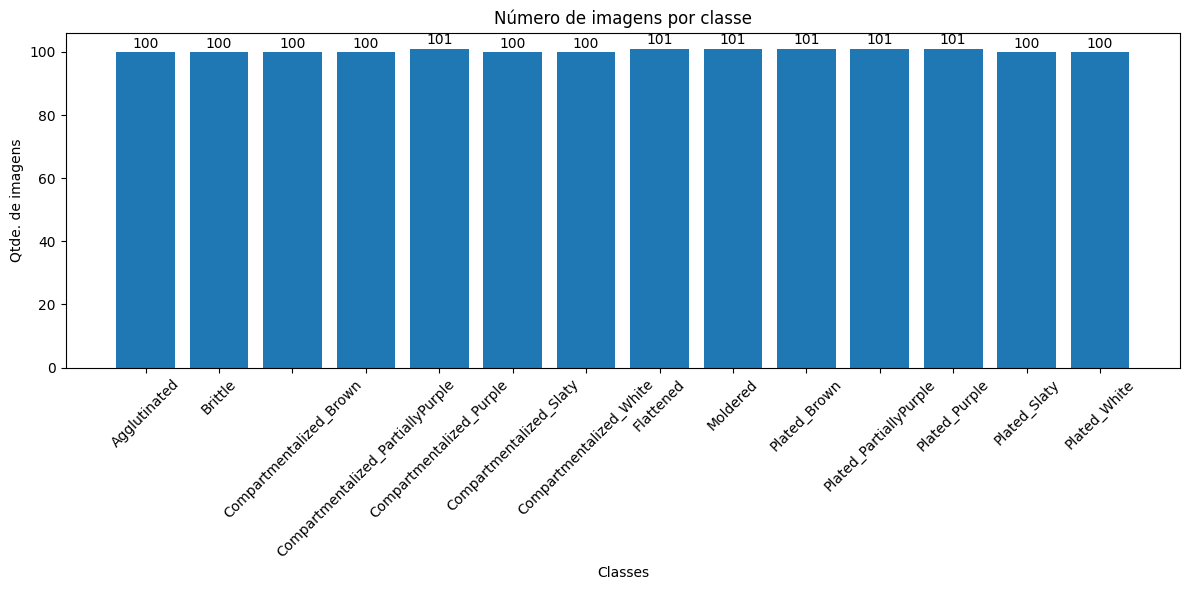

In [5]:
DATASET_PATH = "../data/images/"

classes = []
num_images = []

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        classes.append(class_name)
        num_images.append(len(os.listdir(class_path)))

df = pd.DataFrame({
    "class": classes,
    "num_images": num_images
})

plt.figure(figsize=(12, 6))
bars = plt.bar(df['class'], df['num_images'])

plt.xlabel('Classes')
plt.ylabel('Qtde. de imagens')
plt.title('Número de imagens por classe')
plt.xticks(rotation=45)

plt.bar_label(bars, padding=1)

plt.tight_layout()
plt.show()

In [6]:
images_sizes = []
images_modes = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if not image_name.lower().endswith(valid_extensions):
                continue 
            
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    images_sizes.append(img.size)
                    images_modes.append(img.mode)
            except Exception as e:
                print(f"Erro ao abrir {image_name}: {e}")

print("Tamanhos únicos:", set(images_sizes))
print("Modos de cor:", set(images_modes))

Tamanhos únicos: {(1826, 2035), (1730, 1155), (1234, 1971), (1059, 1890), (1203, 2002), (1251, 2051), (979, 2019), (1330, 2115), (1153, 2419), (1202, 2195), (1114, 2082), (1970, 1091), (1058, 1763), (1043, 2049), (1114, 2338), (1187, 1010), (1185, 1971), (1370, 1379), (1683, 1699), (979, 1875), (1202, 2051), (1155, 1970), (1570, 1651), (931, 2082), (1075, 2355), (1027, 1650), (1187, 2178), (1626, 1075), (994, 2147), (979, 1731), (1027, 1906), (1075, 1955), (1363, 2242), (1666, 1395), (1298, 2131), (1411, 2435), (1027, 2162), (979, 1987), (1683, 1155), (1011, 1827), (1114, 2050), (1059, 2114), (1154, 1619), (1043, 1779), (1315, 1155), (1139, 2003), (1171, 1955), (1075, 2067), (1843, 2195), (1187, 1890), (1122, 2435), (1171, 2211), (1667, 1731), (994, 1859), (1330, 2195), (1594, 1091), (2993, 2770), (1122, 2035), (1466, 2083), (1155, 1794), (1139, 2115), (1011, 2195), (1250, 2211), (1122, 2291), (1171, 2067), (1155, 2050), (1122, 1635), (1043, 2147), (1267, 2291), (1219, 2242), (1011, 17

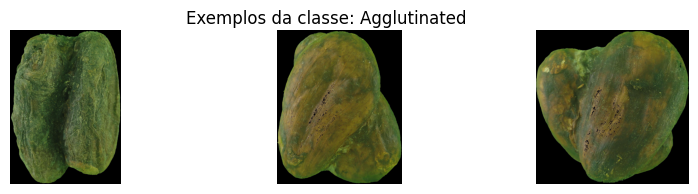

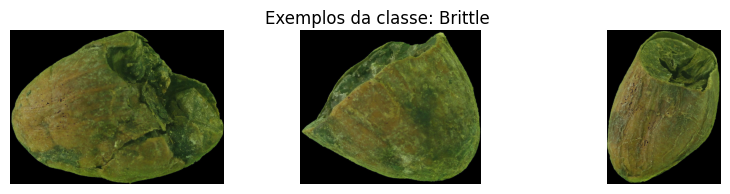

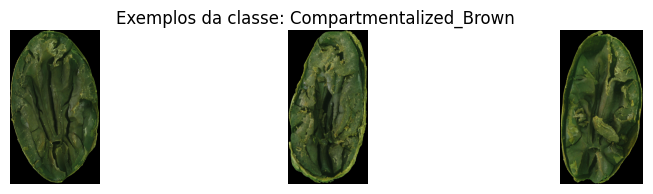

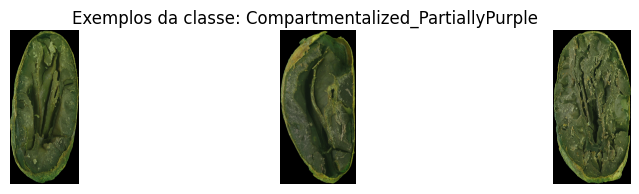

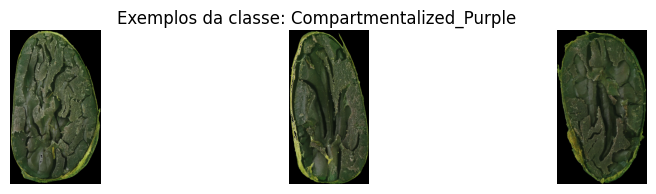

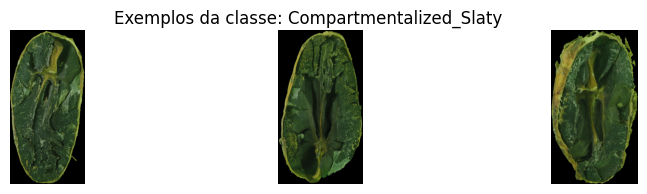

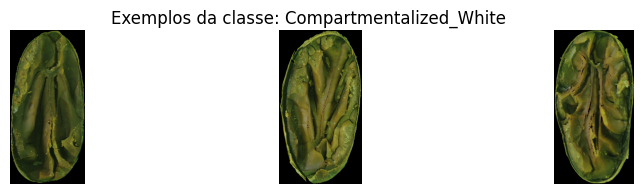

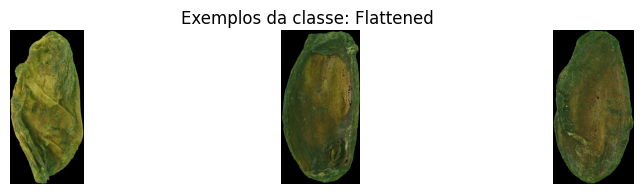

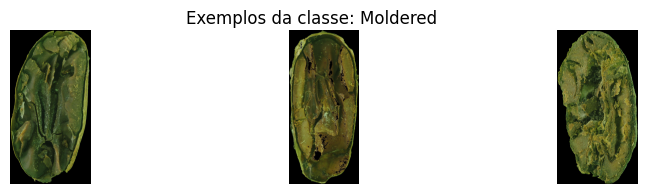

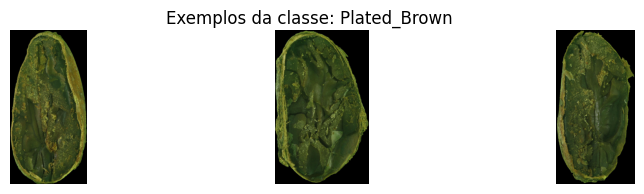

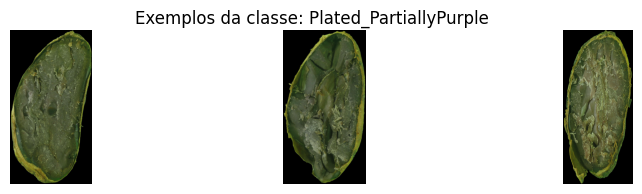

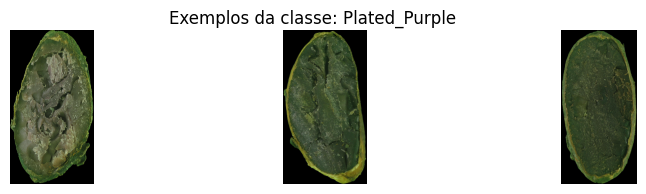

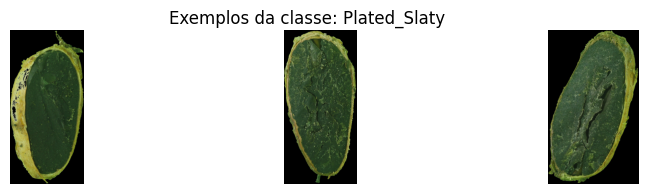

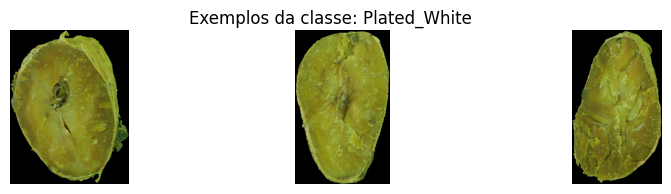

In [7]:
def show_images_from_class(class_name, n=3):
    class_path = os.path.join(DATASET_PATH, class_name)
    
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    all_files = os.listdir(class_path)
    images = [f for f in all_files if f.lower().endswith(valid_extensions)][:n]

    if not images:
        print(f"Nenhuma imagem encontrada na classe {class_name}")
        return

    plt.figure(figsize=(10, 2))
    for i, img_name in enumerate(images):
        try:
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except Exception as e:
            print(f"Erro ao mostrar {img_name}: {e}")
            
    plt.suptitle(f"Exemplos da classe: {class_name}")
    plt.show()

for class_name in classes:
    show_images_from_class(class_name)

#### Etapa 02: Pré-processamento

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [9]:
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

class_names = dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Número de classes:", num_classes)
print("Total de imagens:", len(dataset))

Classes: ['Agglutinated', 'Brittle', 'Compartmentalized_Brown', 'Compartmentalized_PartiallyPurple', 'Compartmentalized_Purple', 'Compartmentalized_Slaty', 'Compartmentalized_White', 'Flattened', 'Moldered', 'Plated_Brown', 'Plated_PartiallyPurple', 'Plated_Purple', 'Plated_Slaty', 'Plated_White']
Número de classes: 14
Total de imagens: 1400


In [10]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Etapa 03: Extração de características

In [12]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)

            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
            
    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

In [13]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
# Sem pré-treinamento: LeNet
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Identity()
    
    def forward(self, x):
        x = self.features(x)
        return x

In [16]:
lenet = LeNet().to(device)

alexnet = models.alexnet(pretrained=True)
alexnet.classifier = nn.Identity()
alexnet = alexnet.to(device)

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier = nn.Identity()
vgg16 = vgg16.to(device)

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Identity()
mobilenet = mobilenet.to(device)

efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier = nn.Identity()
efficientnet = efficientnet.to(device)

c:\Users\kevlo\miniforge3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kevlo\miniforge3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\kevlo\miniforge3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date 

In [17]:
## congelar pesos

models_dict = {
    "lenet": lenet,
    "alexnet": alexnet,
    "vgg16": vgg16,
    # "inception": inception,
    "mobilenet": mobilenet,
    "efficientnet": efficientnet
}

for m in models_dict.values():
    freeze_model(m)

In [18]:
features_dict = {}

for name, model in models_dict.items():
    print(f"{name} extraindo características...")
    X, y = extract_features(model, train_loader, device)
    features_dict[name] = {
        "X": X,
        "y": y
    }
    print(f"{name}: shape = {X.shape}")

lenet extraindo características...
lenet: shape = (979, 44944)
alexnet extraindo características...
alexnet: shape = (979, 9216)
vgg16 extraindo características...
vgg16: shape = (979, 25088)
mobilenet extraindo características...
mobilenet: shape = (979, 1280)
efficientnet extraindo características...
efficientnet: shape = (979, 1280)


In [19]:
output_dir = '../features'

for name, data in features_dict.items():
    np.save(os.path.join(output_dir, f"features_{name}.npy"), data["X"])
    np.save(os.path.join(output_dir, f"labels_{name}.npy"), data["y"])

#### Etapa 04: Busca em Grade com SVM

In [20]:
param_grid = {
    "svm__C": np.logspace(-3, 3, 7),  
    "svm__kernel": ["linear", "rbf"],
    "svm__gamma": ["scale", "auto"]
}

In [21]:
output_file = "resultados_grid_search_final.csv"
results = []

for model_name, data in features_dict.items():
    print(f"Grid Search com SVM usando features do {model_name}")

    try:
        X = data["X"]
        y = data["y"]

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC())
        ])

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=1,
            verbose=1
        )

        grid.fit(X, y)

        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_score = grid.best_score_

        print("Melhores parâmetros:", best_params)
        print("Acurácia média (CV):", best_score)

        results.append({
            "CNN": model_name,
            "Best C": best_params["svm__C"],
            "Kernel": best_params["svm__kernel"],
            "Gamma": best_params["svm__gamma"],
            "CV Accuracy": best_score
        })

        pd.DataFrame(results).to_csv(output_file, index=False)

    except Exception as e:
        print(f"Erro no modelo {model_name}: {e}")

results_df = pd.DataFrame(results).sort_values(
    by="CV Accuracy", ascending=False
)

results_df

Grid Search com SVM usando features do lenet
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Melhores parâmetros: {'svm__C': np.float64(10.0), 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Acurácia média (CV): 0.4872265829408686
Grid Search com SVM usando features do alexnet
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Melhores parâmetros: {'svm__C': np.float64(0.001), 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Acurácia média (CV): 0.6128414442700157
Grid Search com SVM usando features do vgg16
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Melhores parâmetros: {'svm__C': np.float64(0.001), 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Acurácia média (CV): 0.535222396650968
Grid Search com SVM usando features do mobilenet
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Melhores parâmetros: {'svm__C': np.float64(0.001), 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Acurácia média (CV): 0.6598796441653585
Grid Search com 

,CNN,Best C,Kernel,Gamma,CV Accuracy
4,efficientnet,0.010,linear,scale,0.678210
3,mobilenet,0.001,linear,scale,0.659880
1,alexnet,0.001,linear,scale,0.612841
2,vgg16,0.001,linear,scale,0.535222
0,lenet,10.000,rbf,auto,0.487227
